# INSTALL DEPENDENCIES

In [ ]:
!pip install spacy datasets matplotlib seaborn
!python -m spacy download en_core_web_sm

# IMPORTS


In [3]:
import spacy
from spacy.training.example import Example
from spacy.training import Corpus

In [6]:
from datasets import load_dataset

# Load CoNLL-2003 dataset
dataset = load_dataset("conll2003",trust_remote_code=True)

# Train and test split
train_data = dataset["train"]
test_data = dataset["test"]


Generating test split: 100%|██████████| 3453/3453 [00:00<00:00, 8299.64 examples/s]


In [7]:
print(train_data[0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


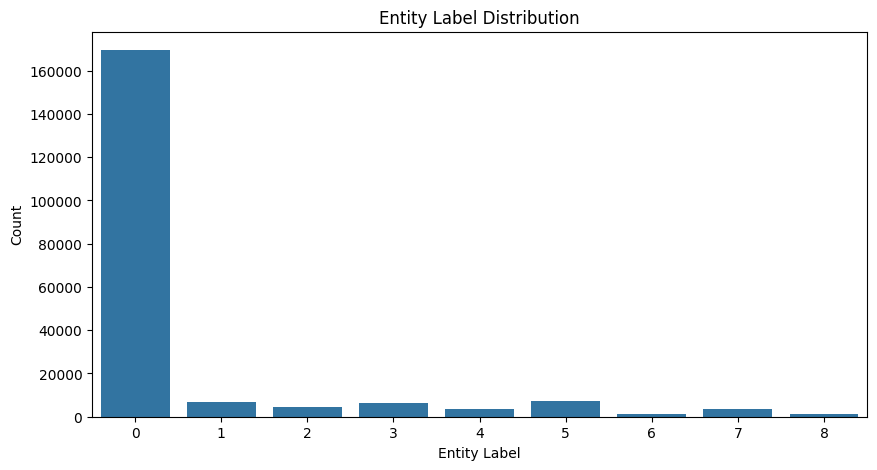

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count entity labels
entity_counts = Counter()
for example in train_data:
    entity_counts.update(example["ner_tags"])

# Plot entity distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
plt.xlabel("Entity Label")
plt.ylabel("Count")
plt.title("Entity Label Distribution")
plt.show()


In [ ]:
import re

def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text) 
    text = re.sub(r"\s+", " ", text).strip()  
    return text

processed_data = []
for example in train_data:
    text = " ".join(example["tokens"]) 
    cleaned_text = clean_text(text)
    processed_data.append({"text": cleaned_text, "ner_tags": example["ner_tags"]})

# Check first entry
print(processed_data[0])


{'text': 'EU rejects German call to boycott British lamb', 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [ ]:
def tokenize_and_label(tokens, ner_tags):
    labels = ner_tags[:len(tokens)]  # Ensure alignment
    return tokens, labels

# Apply tokenization
sample_example = processed_data[0]  # Use fixed processed data
tokens, labels = tokenize_and_label(sample_example["text"].split(), sample_example["ner_tags"])

print("Tokens:", tokens)
print("Labels:", labels)

Tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb']
Labels: [3, 0, 7, 0, 0, 0, 7, 0]


In [17]:
#(TEXT, {"entities": [(start, end, "LABEL")]})

In [23]:
processed_data[:2]

[{'text': 'EU rejects German call to boycott British lamb',
  'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]},
 {'text': 'Peter Blackburn', 'ner_tags': [1, 2]}]

# FORMATTING LABELS
Formatting Labels 

In [24]:
# Define label mapping (CoNLL-2003 uses integer labels)
LABELS = {
    0: "O",        # Outside any entity
    1: "B-PER",    # Beginning of a Person entity
    2: "I-PER",    # Inside a Person entity
    3: "B-ORG",    # Beginning of an Organization entity
    4: "I-ORG",    # Inside an Organization entity
    5: "B-LOC",    # Beginning of a Location entity
    6: "I-LOC"     # Inside a Location entity
}

def format_data_for_spacy(data):
    """
    Converts the dataset into SpaCy's required training format.
    """
    formatted_data = []
    for example in data:
        text = example["text"]
        tokens = text.split()  # Get words
        ner_tags = example["ner_tags"]

        entities = []
        start = 0  # Track character position
        for token, tag in zip(tokens, ner_tags):
            if tag in LABELS and LABELS[tag] != "O":  # Ignore "O" (not an entity)
                end = start + len(token)
                entities.append((start, end, LABELS[tag][2:]))  # Remove "B-" or "I-" prefix
            start += len(token) + 1  # Move start index (considering spaces)

        formatted_data.append((text, {"entities": entities}))

    return formatted_data

# Convert processed data
formatted_train_data = format_data_for_spacy(processed_data)

In [25]:
formatted_train_data[:2]

[('EU rejects German call to boycott British lamb',
  {'entities': [(0, 2, 'ORG')]}),
 ('Peter Blackburn', {'entities': [(0, 5, 'PER'), (6, 15, 'PER')]})]

# TRAINING AND SAVING

Training the model 

In [26]:
import spacy
from spacy.training.example import Example
from spacy.util import minibatch
import random

# Load pre-trained model or create a blank model
nlp = spacy.load("en_core_web_sm")  # Load small English model
ner = nlp.get_pipe("ner")  # Get NER pipeline

# Add new entity labels (if not already in the model)
for _, annotations in formatted_train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])  # ent[2] is the entity label

# Disable other components to train only NER
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

# Training the model
with nlp.disable_pipes(*unaffected_pipes):
    optimizer = nlp.resume_training()  # Get optimizer
    for epoch in range(10):  # Train for 10 epochs
        random.shuffle(formatted_train_data)
        losses = {}

        # Create batches
        batches = minibatch(formatted_train_data, size=8)
        for batch in batches:
            texts, annotations = zip(*batch)  # Unpack batch
            examples = [Example.from_dict(nlp.make_doc(text), annotation) for text, annotation in batch]
            nlp.update(examples, drop=0.3, losses=losses)  # Update model

        print(f"Epoch {epoch+1}, Loss: {losses['ner']}")  # Print loss

# Save trained model
nlp.to_disk("trained_ner_model")
print("Model saved to 'trained_ner_model'!")


Epoch 1, Loss: 26977.345703125
Epoch 2, Loss: 20732.255859375
Epoch 3, Loss: 18361.359375
Epoch 4, Loss: 16961.171875
Epoch 5, Loss: 15757.68359375
Epoch 6, Loss: 14722.0087890625
Epoch 7, Loss: 13876.3779296875
Epoch 8, Loss: 13030.2587890625
Epoch 9, Loss: 12334.796875
Epoch 10, Loss: 11756.0625
Model saved to 'trained_ner_model'!


Saving the model as a pickle file

In [27]:
import pickle
import spacy

# Load the trained model
nlp_trained = spacy.load("trained_ner_model")

# Save the model as a pickle file
with open("trained_ner_model.pkl", "wb") as f:
    pickle.dump(nlp_trained, f)

print("Model saved as 'trained_ner_model.pkl'!")


Model saved as 'trained_ner_model.pkl'!


In [ ]:
TRAIN_DATA = [
    ("Elon Musk is the CEO of SpaceX", {"entities": [(0, 9, "PER"), (22, 28, "ORG")]}),
    ("I live in Paris", {"entities": [(10, 15, "LOC")]}),
    ("Apple was founded by Steve Jobs", {"entities": [(0, 5, "ORG"), (23, 33, "PER")]}),
    ("Microsoft acquired LinkedIn in 2016", {"entities": [(0, 9, "ORG"), (19, 27, "ORG")]}),
    ("Jeff Bezos founded Amazon", {"entities": [(0, 10, "PER"), (19, 25, "ORG")]}),
    ("Sundar Pichai is the CEO of Google", {"entities": [(0, 13, "PER"), (27, 33, "ORG")]}),
    ("I visited the Eiffel Tower in France", {"entities": [(16, 28, "LOC"), (32, 38, "LOC")]}),
    ("The capital of Japan is Tokyo", {"entities": [(16, 21, "LOC"), (25, 30, "LOC")]}),
    ("Facebook was created by Mark Zuckerberg", {"entities": [(0, 8, "ORG"), (25, 39, "PER")]}),
]

In [36]:
n = spacy.load('trained_ner_model')
for x in TRAIN_DATA:
    doc = n(x[0])
    entities = [{"text": ent.text, "label": ent.label_} for ent in doc.ents]
    print(f"\nFor text :- {doc}")
    print(f"Entities are :- {entities}\n")
    print("---------------------")


For text :- Google is a great company
Entities are :- [{'text': 'Google', 'label': 'PER'}]

---------------------

For text :- Elon Musk is the CEO of SpaceX
Entities are :- [{'text': 'Elon', 'label': 'PER'}, {'text': 'Musk', 'label': 'PER'}]

---------------------

For text :- I live in Paris
Entities are :- []

---------------------

For text :- Apple was founded by Steve Jobs
Entities are :- [{'text': 'Steve', 'label': 'PER'}, {'text': 'Jobs', 'label': 'PER'}]

---------------------

For text :- Microsoft acquired LinkedIn in 2016
Entities are :- [{'text': 'Microsoft', 'label': 'ORG'}, {'text': 'LinkedIn', 'label': 'ORG'}]

---------------------

For text :- Jeff Bezos founded Amazon
Entities are :- [{'text': 'Jeff', 'label': 'PER'}, {'text': 'Bezos', 'label': 'PER'}, {'text': 'Amazon', 'label': 'PER'}]

---------------------

For text :- Sundar Pichai is the CEO of Google
Entities are :- [{'text': 'Sundar', 'label': 'PER'}, {'text': 'Pichai', 'label': 'PER'}]

--------------------